# LoRa Data Analysis - Thompson Sampling


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Frequency: 866.1 MHz
- Bandwidth: 125 kHz

End nodes:
- were sending different types of uplink messages.
- were sending a single message each 2 minutes.
- used a Thompson sampling (TS) for communication parameters selection.

Access points:
- only a single access point was used
- capture effect was also considered

Initial declaration

In [14]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib as mpl # import matplotlib
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
import base64
from IPython.display import set_matplotlib_formats # module for svg export

In [15]:
set_matplotlib_formats('svg') # set export to svg file
cut_ratio = 0.05 # Values below 5% of mean value are simply cut from charts to make it more readable

In [39]:
uplink_message_file = './3/uplink_messages.csv'

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [40]:
uplink_data = pd.read_csv(uplink_message_file, delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [41]:
uplink_data.head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,power,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id
0,127284,MTUwNy44LDcyODcuMg==,-14.5,-99.8,36000,t,2021-04-19 08:51:10.805,1,866100000,12,10,1294,4/5,125000,249,1,bbbbbb,OFeD
1,127285,MzM0NS4zLDY4NjkuNA==,4.3,-89.6,36000,t,2021-04-19 08:51:16.354,1,866100000,8,10,102,4/5,125000,405,1,bbbbbb,7wPG
2,127286,NDU5OC45LDQxMjEuMg==,-19.7,-66.6,36000,t,2021-04-19 08:51:21.894,1,866100000,9,14,183,4/5,125000,284,1,bbbbbb,LPcK
3,127287,MjE3OS4yLDE4OTguMg==,5.8,-99.9,36000,t,2021-04-19 08:51:26.936,1,866100000,11,10,714,4/5,125000,98,1,bbbbbb,pAEx
4,127288,ODk5Ny4xLDE5MjguMg==,0.6,-99.6,36000,t,2021-04-19 08:51:31.424,1,866100000,8,14,102,4/5,125000,326,2,bbbbbb,DPPo


Remove all columns that have fixed values or there is no point in their analysis.

In [42]:
try:
    del uplink_data['id']
    del uplink_data['msg_group_number']
    del uplink_data['is_primary']
    del uplink_data['coderate']
    del uplink_data['bandwidth']
    del uplink_data['receive_time']
except KeyError:
    print('Columns have already been removed')

Let us create a new column 'arm'. This columns represents a combination of SF and TP and is referred in multi-armed bandit terminology as arm.

In [43]:
uplink_data['arm'] = 'S' + uplink_data.spf.astype(str) + 'P' + uplink_data.power.astype(str)

### Communication parameters selection

In [21]:
arms = uplink_data.arm.value_counts()
threshold = round(statistics.mean(uplink_data.arm.value_counts()) * cut_ratio, 2)
print(f'Values below {threshold} will be cut from a plot')
arms = arms[arms > threshold]

Values below 18.05 will be cut from a plot


Text(0, 0.5, 'Number of Messages')

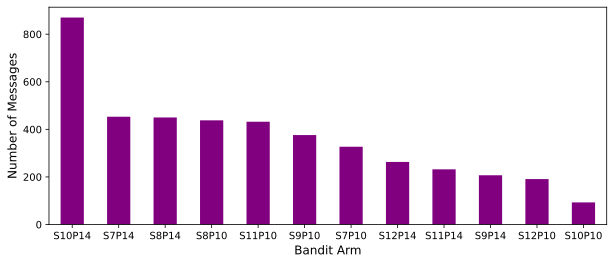

In [22]:
# set_matplotlib_formats('svg')
hist = arms.plot(kind='bar',rot=0, color='purple',figsize=(10,4))
hist.set_xlabel("Bandit Arm",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

Export plot to SVG.

In [25]:
hist.get_figure().savefig('ts-bandit-arms.svg', dpi=300)

### Spreading Factor

Text(0, 0.5, 'Number of Messages')

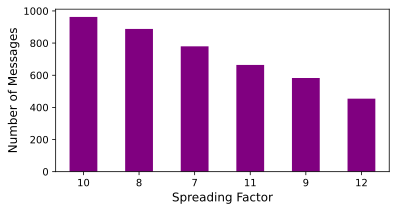

In [28]:
hist = uplink_data.spf.value_counts().plot(kind='bar',rot=0,color='purple',figsize=(6,3))
hist.set_xlabel("Spreading Factor",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

All nodes used the same frequency to increase a probability of collisions.

We have only a single Access Point.

### Duration of Data Transmission

In [29]:
airtime = uplink_data.airtime.value_counts()
threshold = 100
airtime = airtime.loc[lambda x : x > threshold]
print(f'Values with low then {threshold} occurences will be cut from a plot')

Values with low then 100 occurences will be cut from a plot


Text(0, 0.5, 'Number of Messages')

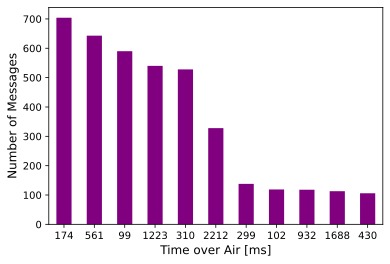

In [31]:
hist = airtime.plot(kind="bar",rot=0,color='purple')
hist.set_xlabel("Time over Air [ms]",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

In [32]:
hist.get_figure().savefig('ts-airtime.svg', dpi=300)

### Transmission Power

Only two transmission power values were possible in this scenario.

To increase TP a value of 14 was used, to decrease TP a value of 10 was used.

Text(0, 0.5, 'Number of Messages')

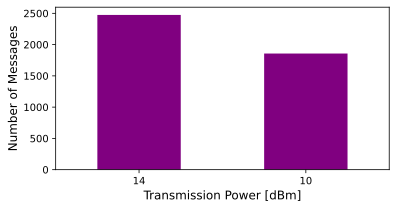

In [33]:
hist = uplink_data.power.value_counts().plot(kind="bar",rot=0,color='purple',figsize=(6,3))
hist.set_xlabel("Transmission Power [dBm]",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

### Different Types of Messages

Let us analyze the ratio of message types.

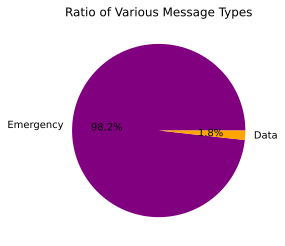

In [45]:
message_types = uplink_data.message_type_id.value_counts()

plt.pie(message_types, autopct='%1.1f%%', labels=['Emergency', 'Data'], colors=['purple', 'orange'])
plt.title('Ratio of Various Message Types')
plt.show()

In [47]:
plt.savefig('ts-message-types.svg', dpi=300)

<Figure size 432x288 with 0 Axes>

## Analysis of End Nodes

Analysis of certain aspects (active time, sleep time and collisions) of end devices.

In [48]:
print(f'Number of end nodes partiipating in the experiment is {uplink_data.node_id.nunique()}.')

Number of end nodes partiipating in the experiment is 97.


In [49]:
uplink_data.node_id.describe()

count     4332
unique      97
top       EINI
freq        70
Name: node_id, dtype: object

In [50]:
unique_ens = len(uplink_data.node_id.unique())
unique_aps = len(uplink_data.ap_id.unique())

In [51]:
print(f'Total number of connected end devices: {unique_ens}')
print(f'Total number of connected access points: {unique_aps}')

Total number of connected end devices: 97
Total number of connected access points: 1


In [52]:
end_nodes = pd.read_csv('./3/ts - experiment - 3 - 100 - bbbbbb.csv', delimiter=',')

In [53]:
end_nodes.head()

,dev_id,active_time,uptime,collisions,messages
0,BaJH,1.32,24.74,3,205
1,DCCr,0.34,24.80,4,203
2,tmZ5,0.33,24.63,2,203
3,CeKC,0.07,24.55,3,204
4,d67c,0.64,24.61,5,200


### Collision histogram

Cutting values is disabled.

In [54]:
no_collisions = end_nodes.collisions.value_counts()
threshold = statistics.mean(end_nodes.collisions.value_counts())
print(f'Values below {threshold} will be cut in a plot')

Values below 7.071428571428571 will be cut in a plot


In [55]:
collisions = end_nodes.collisions[end_nodes.collisions > threshold]
collisions.describe()

count    18.000000
mean     11.222222
std       4.180565
min       8.000000
25%       8.250000
50%      10.000000
75%      13.000000
max      25.000000
Name: collisions, dtype: float64

In [56]:
max_collisions = max(collisions)
min_collisions = min(collisions)
range_collisions = max_collisions - min_collisions
increment = math.ceil(range_collisions / 4)

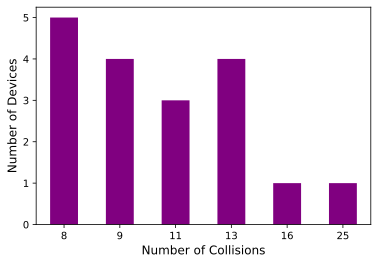

In [57]:
#out = pd.cut(collisions, bins=[min_collisions, min_collisions + increment, min_collisions + 2 * increment, min_collisions + 3 * increment, max(collisions)], include_lowest=True)
hist = collisions.value_counts(sort=False).plot.bar(rot=0,color='purple')
hist.set_xlabel("Number of Collisions",fontsize=12)
hist.set_ylabel("Number of Devices",fontsize=12)
plt.show()

In [60]:
hist.get_figure().savefig('ts-collisions.svg', dpi=300)

### Ration between active time and total nodes uptime

In [61]:
energy = (end_nodes.active_time / end_nodes.uptime)

In [62]:
energy.describe()

count    99.000000
mean      0.030277
std       0.044012
min       0.000000
25%       0.002390
50%       0.011076
75%       0.045921
max       0.244970
dtype: float64

In [100]:
active_time = round(statistics.mean(energy) * 100, 2)
print(f'The nodes spent {active_time}% of their uptime in active mode.')

The nodes spent 3.03% of their uptime in active mode.


### Packet Delivery Ratio

Evaluation of packet delivery ratio for end nodes.

In [93]:
end_nodes['pdr'] = round((1 - (end_nodes.collisions / end_nodes.messages))*100, 2)
pdr = end_nodes.pdr

In [94]:
mean_pdr = round(statistics.mean(pdr), 2)
print(f'Mean value of Packet Delivery Ratio is {mean_pdr}%.')

Mean value of Packet Delivery Ratio is 97.69%.


In [95]:
max_pdr = max(pdr)
min_pdr = min(pdr)
range_pdr = max_pdr - min_pdr
increment = math.ceil(range_pdr / 4)

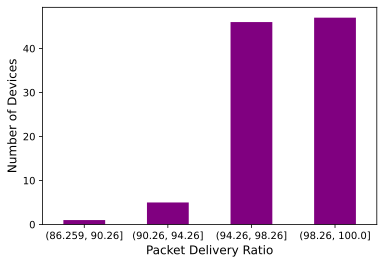

In [99]:
out = pd.cut(pdr, bins=[min_pdr, min_pdr + increment, min_pdr + 2 * increment, min_pdr + 3 * increment, max_pdr], include_lowest=True)
hist = out.value_counts(sort=False).plot.bar(rot=0,color='purple')
hist.set_xlabel("Packet Delivery Ratio",fontsize=12)
hist.set_ylabel("Number of Devices",fontsize=12)
plt.show()

## Path of Each End Node

Data about position are encoded as base64.

Decode base64, extract position and save the results to original data frame.

In [64]:
try:
    app_data = uplink_data.app_data.apply(base64.b64decode)
    app_data = app_data.astype(str)
    app_data = app_data.str.split(',')

    df = pd.DataFrame({}, columns = ['node_id', 'x', 'y'])

    x = []
    y = []

    for row in app_data:
        x.append(round(float(row[1].split('\'')[0]), 2))
        y.append(round(float(row[0].split('\'')[1]), 2))

    uplink_data['x'] = x
    uplink_data['y'] = y
    
    del uplink_data['app_data']
except KeyError:
    print('Column has already been removed')

In [65]:
uplink_data.head()

,snr,rssi,duty_cycle_remaining,seq,frequency,spf,power,airtime,message_type_id,ap_id,node_id,arm,x,y
0,-14.5,-99.8,36000,1,866100000,12,10,1294,1,bbbbbb,OFeD,S12P10,7287.2,1507.8
1,4.3,-89.6,36000,1,866100000,8,10,102,1,bbbbbb,7wPG,S8P10,6869.4,3345.3
2,-19.7,-66.6,36000,1,866100000,9,14,183,1,bbbbbb,LPcK,S9P14,4121.2,4598.9
3,5.8,-99.9,36000,1,866100000,11,10,714,1,bbbbbb,pAEx,S11P10,1898.2,2179.2
4,0.6,-99.6,36000,1,866100000,8,14,102,2,bbbbbb,DPPo,S8P14,1928.2,8997.1


Now, we draw a path for each end node based on the received coordinates.

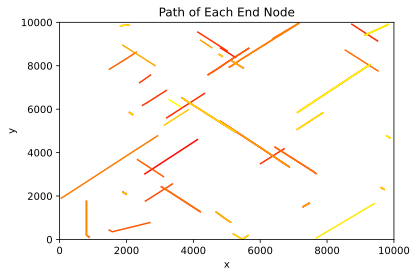

In [67]:
unique_ens = len(uplink_data.node_id.unique())
cmap = mpl.cm.autumn

for i in range(0, unique_ens):
    data = uplink_data[uplink_data.node_id == uplink_data.node_id[i]]
    plt.plot(data.x, data.y, color=cmap(i / unique_ens))

plt.title('Path of Each End Node')
plt.ylabel('y')
plt.xlabel('x')

plt.xlim([0,10000])
plt.ylim([0,10000])

plt.show()

In [68]:
plt.savefig('ts-path.svg', dpi=300)

<Figure size 432x288 with 0 Axes>